In [ ]:
# !pip install --quiet diffrax

# import logging
# logger = logging.getLogger()
# class CheckTypesFilter(logging.Filter):
#     def filter(self, record):
#         return "check_types" not in record.getMessage()
# logger.addFilter(CheckTypesFilter())

     |████████████████████████████████| 140 kB 36.5 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.2 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# Let's make a toy distribution, this will be our likelihood, it depends
# on sigma, which is the amount of gaussian noise we add
def make_likelihood(sigma=0.):
  """
  Returns a mixture of Gaussians, convolved with a Gaussian of specified sigma
  """
  return tfd.Normal(2.5, jnp.sqrt(0.1**2 +sigma**2) )

# And now let's build a simple prior distribution
def make_prior(sigma):
  return tfd.Normal(0, jnp.sqrt(0.5+sigma**2))

In [3]:
def score_fn(t,x):
  return (jax.grad(
      lambda x: make_likelihood(t).log_prob(x**2) + make_prior(t).log_prob(x)))(x)

## Test 1: run langevin dynamics from a not to crazy starting point

So here I'm going to sample from the prior term, and let the langevin dynamic run for a bit, at fixed temperature

In [4]:
from scipy.integrate import simps

In [5]:
t0, t1 = 2., 0.

drift = lambda t, y, args: - 0.5 * score_fn(1.0, y)
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()

@jax.jit
@jax.vmap
def get_samples(y, seed):
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-6, shape=(), key=seed)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000).ys[0]

In [6]:
initial_samples = make_prior(1.).sample(100_000, seed=jax.random.PRNGKey(13))
res = get_samples(initial_samples,
                  jax.random.split(jax.random.PRNGKey(3), 100_000))

2023-12-19 00:15:30.592343: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(-3.0, 3.0)

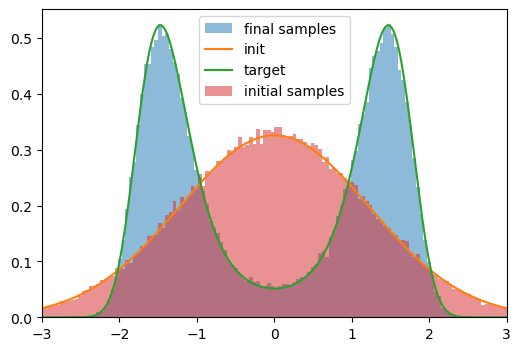

In [16]:
x = jnp.linspace(-10,10,1024)

plt.figure(figsize=(6,4))
plt.hist(res,128,range=[-3,3], density=True, label='final samples', alpha=0.5);
plt.plot(x, make_prior(1.).prob(x), label='init')
posterior = make_likelihood(1.).prob(x**2)*make_prior(1.).prob(x)
plt.plot(x, posterior/simps(posterior,x), label='target')
plt.hist(initial_samples,128,range=[-3,3], density=True, label='initial samples',alpha=0.5);
plt.legend()
plt.xlim(-3,3)

OK, I get samples from the distribution I wanted

In [17]:
ref_samples = res+0

## Decreasing sigma as the SDE evolves in time

So, now I start from the samples above which correspond to sigma=1, and I run an SDE with the temperature slowly decreasing, giving enough time to reach equilibrium

In [39]:
t0, t1 = 5., 0.
drift = lambda t, y, args: - 0.5 * score_fn(t/t0, y) # Now sigma is a function of time
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()
saveat = SaveAt(ts=jnp.linspace(t0,t1))

@jax.jit
@jax.vmap
def get_samples(y, seed):
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(), key=seed)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000, saveat=saveat).ys

In [40]:
res = get_samples(ref_samples,
                  jax.random.split(jax.random.PRNGKey(8), 100_000))

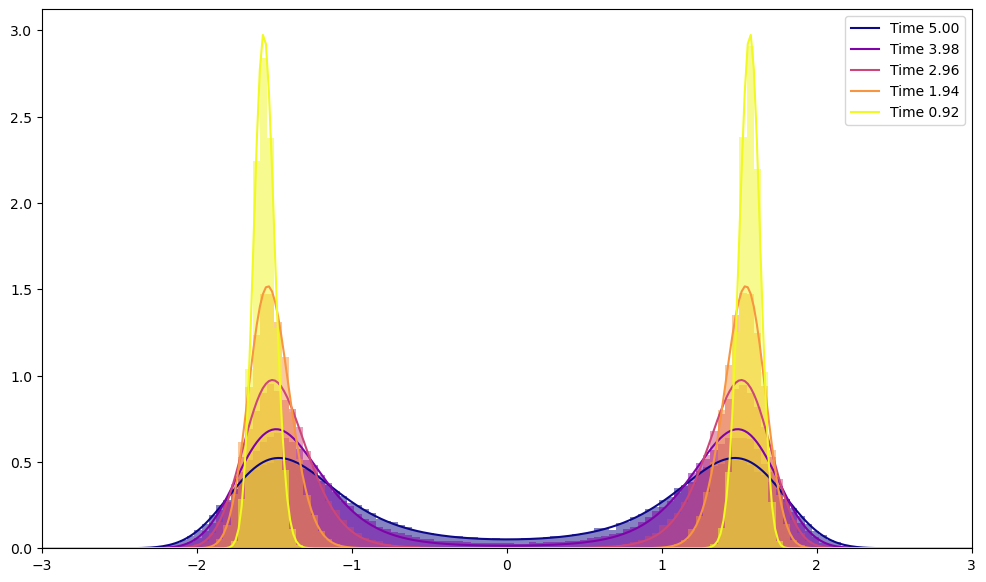

In [38]:
# T=5
colors = plt.cm.plasma(np.linspace(0,1,5))

plt.figure(figsize=[12,7])
for i,t in enumerate(saveat.subs.ts[::10]):
  posterior = make_likelihood(t/t0).prob(x**2)*make_prior(t/t0).prob(x)
  plt.plot(x, posterior/simps(posterior,x),color=colors[i], label='Time %0.2f'%t)
  plt.hist(res[:,i*10],128,range=[-3,3], density=True,alpha=0.5,color=colors[i]);
plt.xlim(-3,3);
plt.legend();

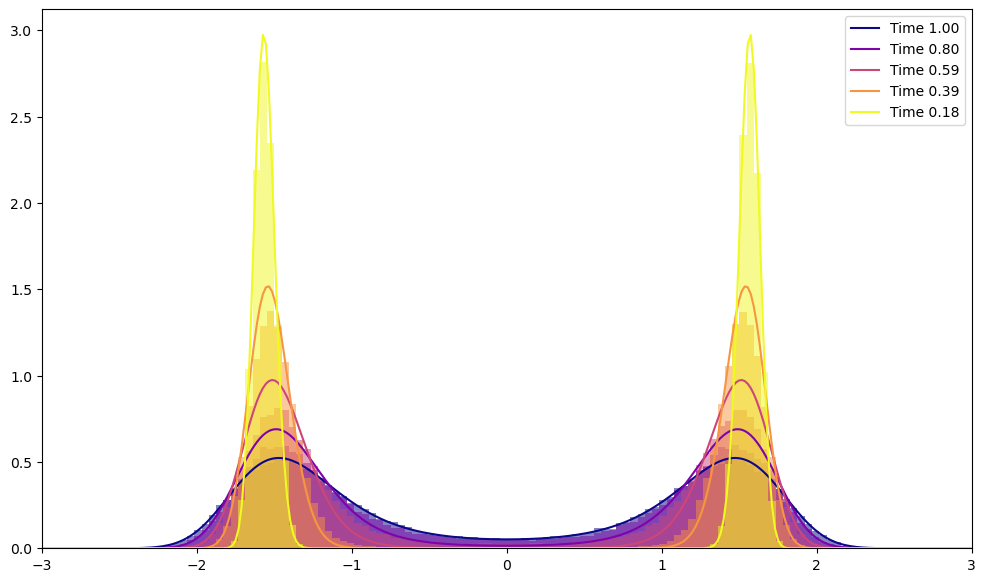

In [41]:
# T=1
colors = plt.cm.plasma(np.linspace(0,1,5))

plt.figure(figsize=[12,7])
for i,t in enumerate(saveat.subs.ts[::10]):
  posterior = make_likelihood(t/t0).prob(x**2)*make_prior(t/t0).prob(x)
  plt.plot(x, posterior/simps(posterior,x),color=colors[i], label='Time %0.2f'%t)
  plt.hist(res[:,i*10],128,range=[-3,3], density=True,alpha=0.5,color=colors[i]);
plt.xlim(-3,3);
plt.legend();